## Reference
1. Ke, Zheng and Kelly, Bryan T. and Xiu, Dacheng, Predicting Returns with Text Data (July 30, 2019). University of Chicago, Becker Friedman Institute for Economics Working Paper No. 2019-69; Yale ICF Working Paper No. 2019-10. Available at SSRN: https://ssrn.com/abstract=3389884
2. Repetto, M. (2020). mrepetto94/sentiment_modelling. [online] GitHub. Available at: https://github.com/mrepetto94/sentiment_modelling [Accessed 14 Mar. 2021].

In [175]:
# load the packages 
import pandas as pd
import numpy as np
from scipy import spatial
import datetime

import beautifultools as bt
import qgrid
from pandas.core.common import flatten
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats


In [74]:
# import the dataset
wsj = pd.read_csv('..//data/wsj_full.csv') # wsj dataset
sp100 = pd.read_csv('..//data/LogReturnData.csv')

# select the relevant topics
tp_li = [1, 2, 5, 7, 9, 10, 16, 21, 24, 15]
wsj_selected = wsj[wsj['Topic_Num'].isin(tp_li)] 

# only the log returns of S&P100 is selected
oex = sp100[['Date', '^OEX']]


In [75]:
# label the return with positive & negative, 1 refers to positive log return, 0 refers to negative log return
oex['direction'] = 1
oex.loc[oex[oex['^OEX'] < 0].index, 'direction'] = 0

# drop NaN value
oex = oex.dropna()

/home/ec2-user/SageMaker/.conda/envs/sample_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ec2-user/SageMaker/.conda/envs/sample_env/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [76]:
wsj1 = wsj_selected.copy() # make a copy of wsj_selected

# select relevant columns, polarity calculated with Mcdonald dict for future comparison
wsj1 = wsj1[['Title', 'Text', 'Date', 'Polarity']]

# combine the direction of sp100 with wsj news
df = wsj1.set_index('Date').join(oex.set_index('Date'))

# remove NaN value
df = df.dropna()

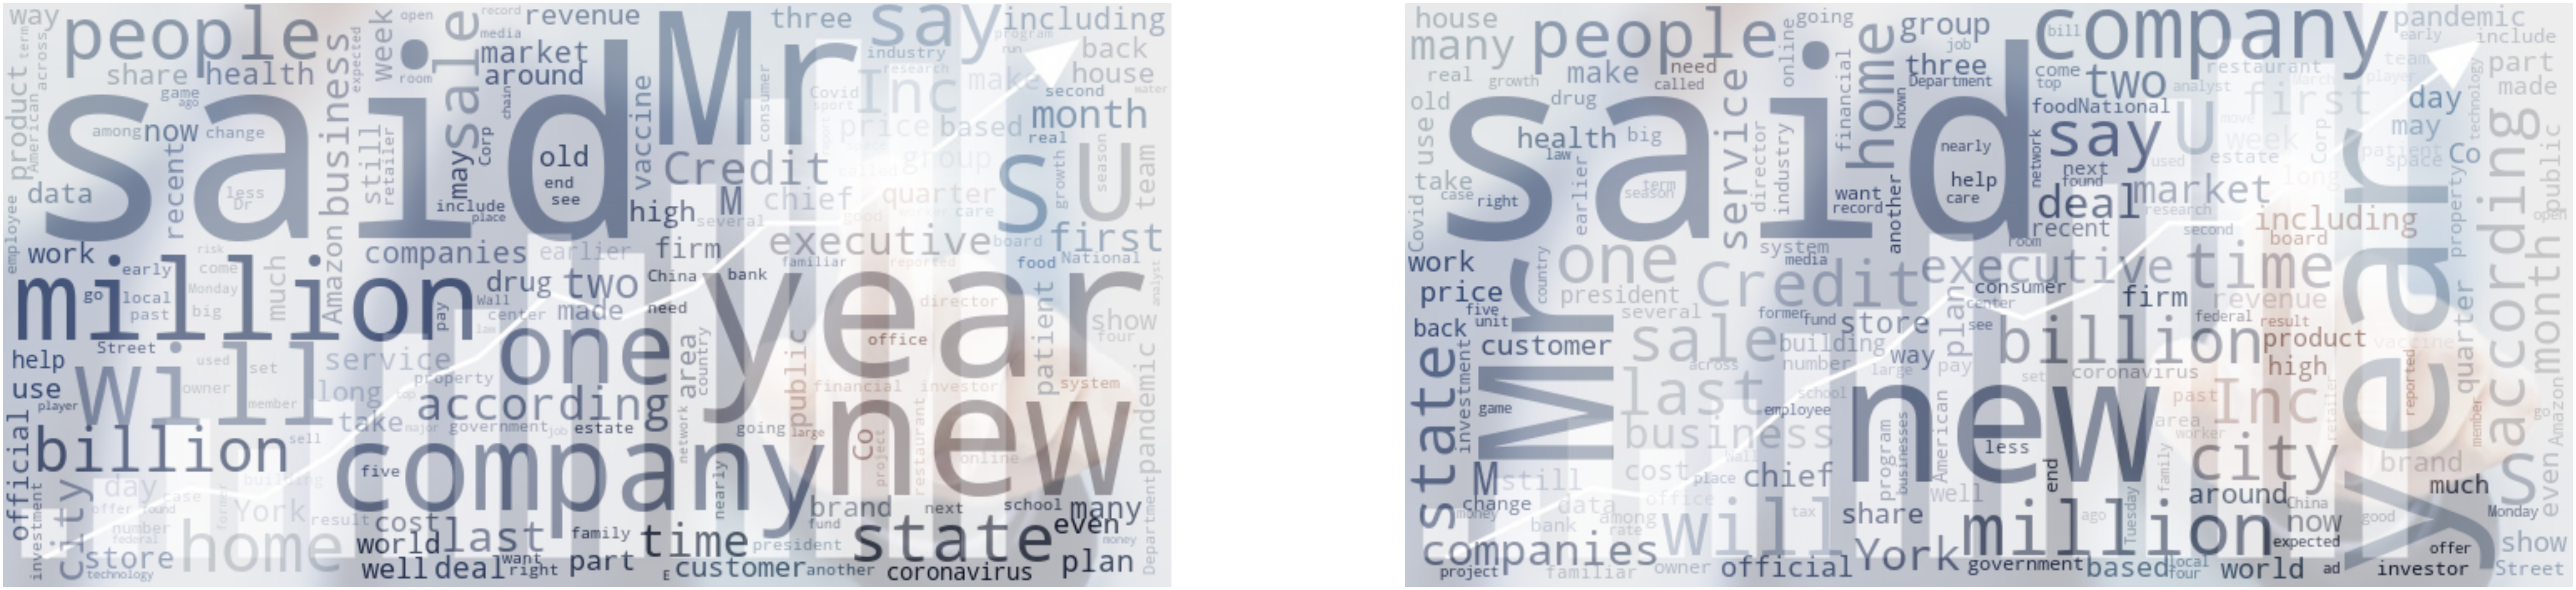

In [128]:
# word cloud of negative, positive articles
bt.word_cloud([
    " ".join(df.loc[df['direction'] == i]['Text'].tolist())
    for i in [0, 1]],
    maskPath = 'invest.jpeg',
    figsize = (100, 80))

# The differences are not really obvious

In [ ]:
# get the seed set that signals positive, or negative movement

In [130]:
# train the model
res = bt.SSESTM(alpha_minus=0.5, alpha_plus=0.5, kappa=3).fit(X=df["Text"],
                                                              y=df["direction"])

/home/ec2-user/SageMaker/cx_WSJ/beautifultools.py:596: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  tildeD = dS / s[:, None]


In [132]:
# Creates the topic matrix containing the sentiment information of each sentiment charged word
topicMatrix = pd.DataFrame({
    "S": res.marginal_screening["term"],
    "Op": res.topic_coefficients[:, 0],
    "Om": res.topic_coefficients[:, 1]
})

topicMatrix.head()

S            Op            Om
0    00  0.000000e+00  0.000000e+00
1   000  0.000000e+00  0.000000e+00
9   004  0.000000e+00  0.000000e+00
11  007  5.826329e-07  6.874830e-07
14   01  0.000000e+00  0.000000e+00

In [133]:
df["pred"] = res.predict(df["Text"])

/home/ec2-user/SageMaker/cx_WSJ/beautifultools.py:678: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  D = dS / s[:, None]


In [157]:
# create a column of index
df['Date'] = df.index
df = df.reset_index(drop = True)

In [177]:
# convert date from str to datetime
df['Date'] = df['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date())

In [178]:
# create a column of month 
df['Month'] =[d.strftime('%b') for d in df['Date']]

In [159]:
df1 = df.groupby(by = 'Date')['Polarity', 'pred'].mean()

/home/ec2-user/SageMaker/.conda/envs/sample_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='Date'>

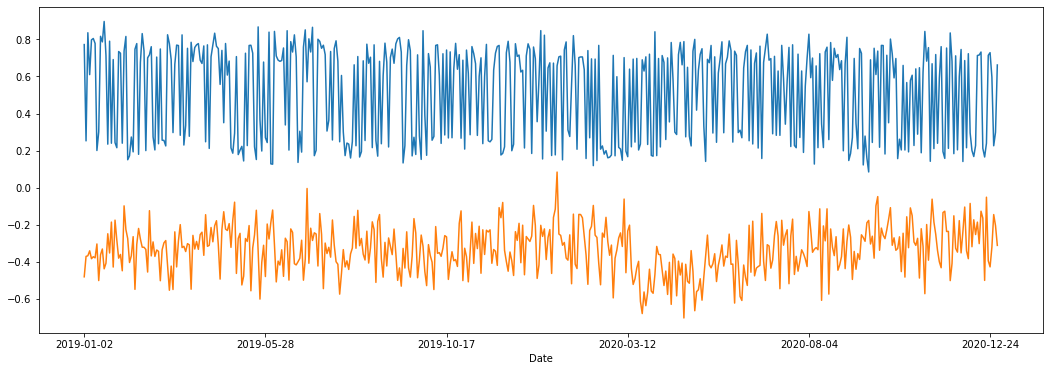

In [180]:
# rescale the polarity before plotting
plt.subplots(figsize = (18, 6))
df1['pred'].plot()
df1['Polarity'].plot()